检索增强生成（RAG）通常与大型语言模型（LLM）一起使用，是一种使用外部知识并减少LLM幻觉的方法。然而，基本RAG有时候并不总是有很好的效果的，有可能从向量数据库中检索出与用户提示不相关的文档，导致LLM无法总结出正确的答案。

本文介绍三种Langchain提供的方法来提高RAG效果，具体如下：

# ​一、Multi Query Retriever[1]

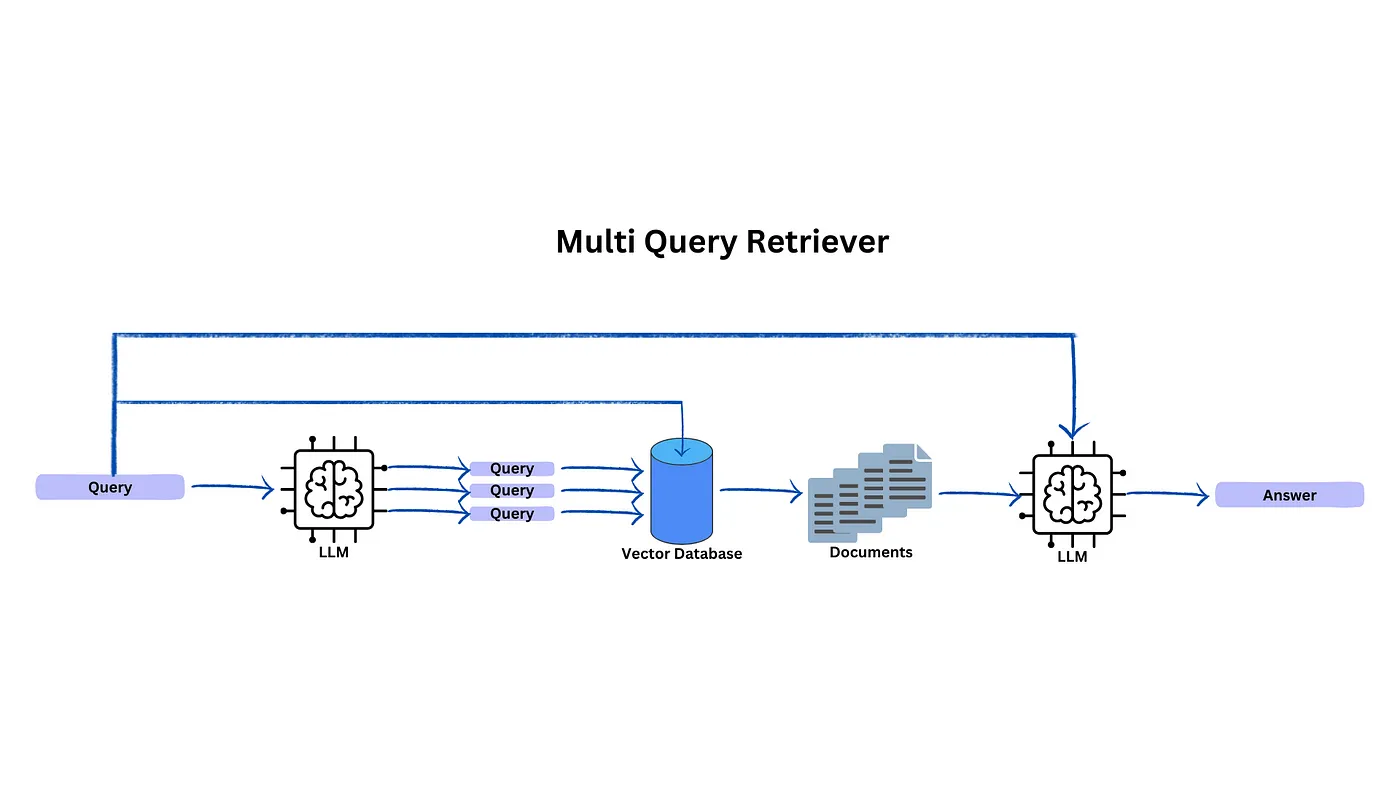

多查询检索器是对查询扩展的一种形式。原理是：使用llm对原始查询中生成更多的问题，并且每个生成的问题都会进行检索相关文档。这种技术试图回答一些用户提示没有那么具体的情况。

代码实现如下：

In [5]:
!pip install langchain langchain_community openai chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.5 MB/s eta 0:00:00


In [14]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

os.environ["OPENAI_API_KEY"] = "Your Open AI KEY"

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

#---------------------------Prepare Multi Query Retriever--------------------
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import ChatOpenAI

question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

#----------------------Setup QnA----------------------------------------
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate


qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \
​
        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format_docs(docs):
    doc_strings = [doc.page_content for doc in docs]
    return "\n\n".join(doc_strings)


rag_chain = (
    {"context": retriever_from_llm | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What are the approaches to Task Decomposition?")

以上问题的答案是

There are three approaches to task decomposition:
​
1. LLM with simple prompting: This approach involves using a language model like GPT-3 to generate step-by-step instructions for a given task. The model can be prompted with a simple instruction like "Steps for XYZ" and it will generate a list of subgoals or steps to achieve the task.
​
2. Task-specific instructions: This approach involves providing task-specific instructions to guide the decomposition process. For example, if the task is to write a novel, the instruction could be "Write a story outline." This approach helps to provide more specific guidance and structure to the decomposition process.
​
3. Human inputs: This approach involves involving human inputs in the task decomposition process. Humans can provide their expertise and knowledge to break down a complex task into smaller, more manageable subtasks. This approach can be useful when dealing with tasks that require domain-specific knowledge or expertise.
​
These approaches can be used individually or in combination depending on the nature of the task and the available resources.

# 二、Long Context Reorder[2]

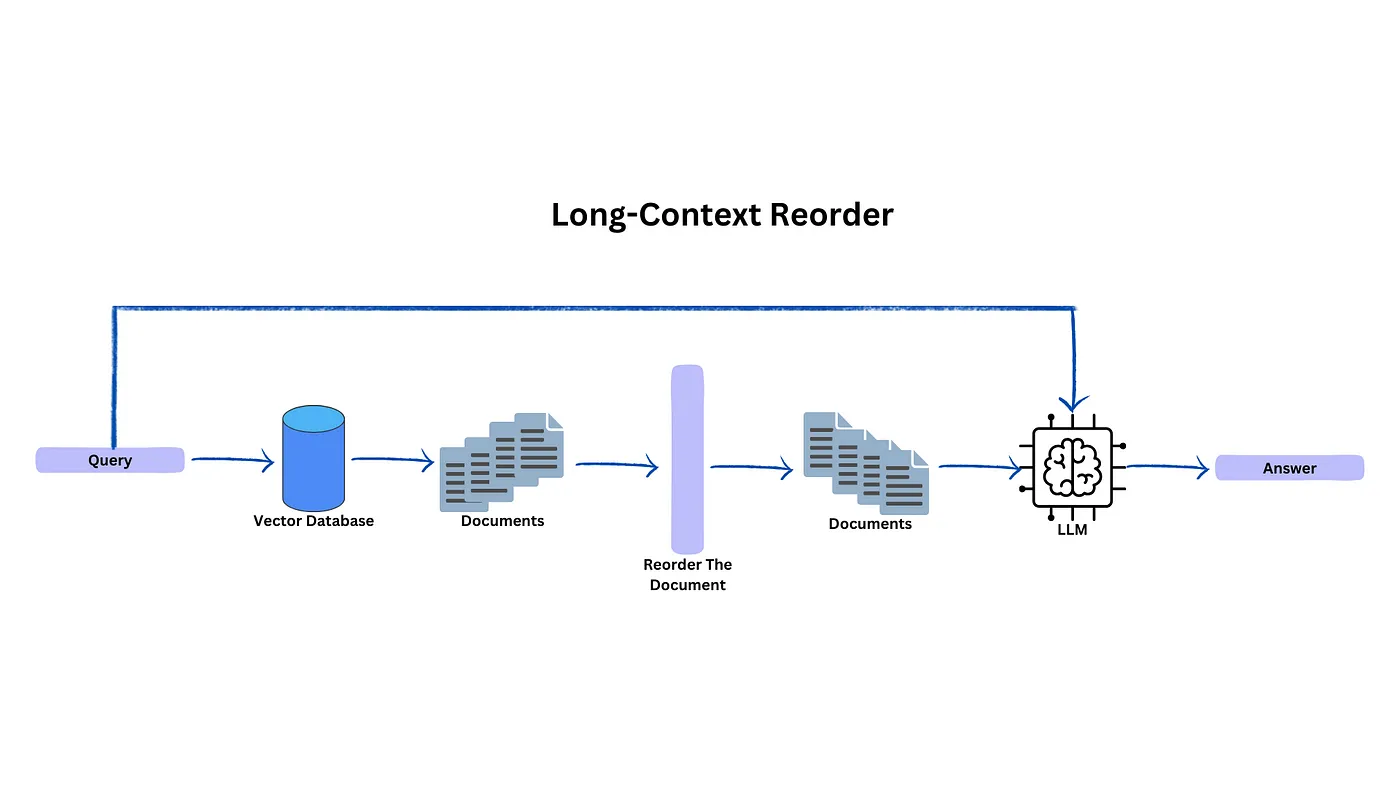

长上下文重排序非常适合于我们想要从矢量数据库返回10个以上文档的情况。为什么我们需要召回那么多文件？也许，我们的块很短，矢量数据库存储了很多块。

当LLM对这么多文档提出问题时，在某些情况下，LLM无法理解位于检索文档中间的文档的上下文。

思路来自论文《Lost in the Middle: How Language Models Use Long Contexts》[3]。

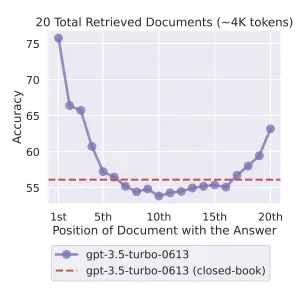

Langchain提供了对应的函数来解决上述问题，该函数可以帮助重新排序相关文档，这样可以确保相关文档位于文档列表的开头和末尾。

代码实现如下所示：

In [ ]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

os.environ["OPENAI_API_KEY"] = "Your Open AI KEY"

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

#--------------------------------QnA Part and Reordering------------------------------------
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_transformers import (
    LongContextReorder,
)

llm = ChatOpenAI()

qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \
​
        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format_docs(docs):
    #Called the reordering function in here
    reordering = LongContextReorder()
    reordered_docs = reordering.transform_documents(docs)
    doc_strings = [doc.page_content for doc in reordered_docs]
    return "\n\n".join(doc_strings)


rag_chain = (
    {"context": vectordb.as_retriever() | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)
rag_chain.invoke("What are the approaches to Task Decomposition?")

以上问题的答案是

There are three approaches to task decomposition:
​
1. LLM with simple prompting: This approach involves using simple prompts to guide the agent in breaking down a task into smaller subgoals. For example, the agent can be prompted with "Steps for XYZ" or "What are the subgoals for achieving XYZ?" This approach relies on the language model's ability to generate appropriate subgoals based on the given prompts.
​
2. Task-specific instructions: In this approach, task decomposition is done by providing task-specific instructions to the agent. For example, if the task is to write a novel, the agent can be instructed to "Write a story outline." This approach provides more specific guidance to the agent in decomposing the task.
​
3. Human inputs: Task decomposition can also be done with the help of human inputs. This approach involves receiving input or guidance from a human to break down the task into smaller subgoals. The human input can be in the form of instructions, suggestions, or feedback provided to the agent.

# 三、Contextual Compression[4]

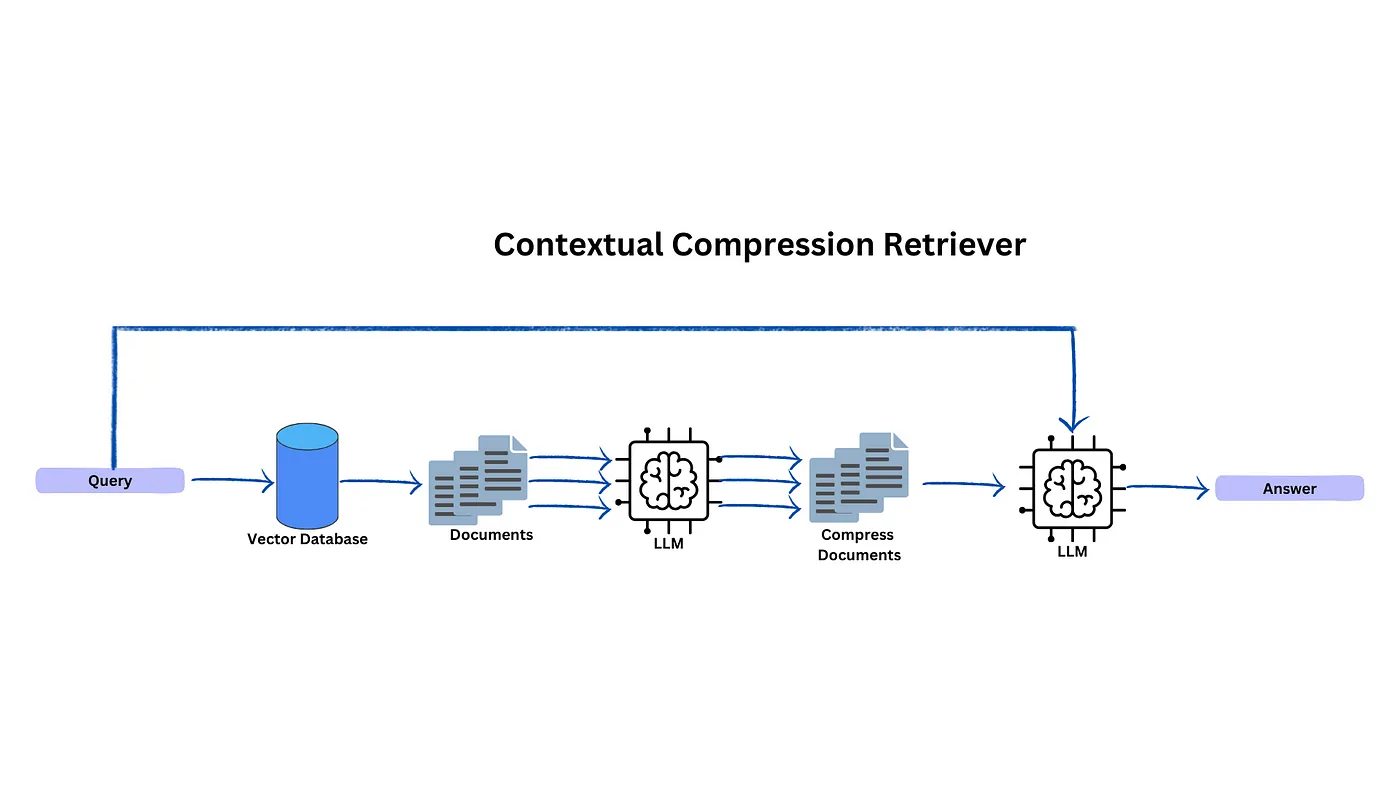

在某些情况下，我们的向量数据库中的每个块中的令牌数量都很高，并且每个块有时会包含一些不相关的信息。为了使LLM能够正确地进行总结，我们需要使用LLM从检索到的文档中删除那些不相关的段落。Langchain提供了上下文压缩文档技术来解决该问题。

代码如下所示：

In [ ]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

os.environ["OPENAI_API_KEY"] = "Your Open AI API KEY"

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

#----------------------------Contextual Compression Setup---------------------
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers import ContextualCompressionRetriever

splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_compressor, base_retriever=vectordb.as_retriever()
)

#--------------------------------QnA Part------------------------------------
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI()

qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \
​
        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format_docs(docs):
    doc_strings = [doc.page_content for doc in docs]
    return "\n\n".join(doc_strings)


rag_chain = (
    {"context": compression_retriever | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What are the approaches to Task Decomposition?")

以上问题的答案是

There are several approaches to task decomposition:
​
1. LLM with simple prompting: This approach involves using a large language model (LLM) like OpenAI's GPT-3 to decompose tasks. By providing simple prompts such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?", the LLM can generate a list of subgoals or steps necessary to complete the task.
​
2. Task-specific instructions: In this approach, task decomposition is guided by providing specific instructions tailored to the task at hand. For example, if the task is to write a novel, the instruction could be "Write a story outline." This helps the agent break down the task into smaller components and focus on each step individually.
​
3. Human inputs: Task decomposition can also be done with the help of human inputs. Humans can provide guidance, expertise, and domain-specific knowledge to assist in breaking down complex tasks into manageable subgoals. This approach leverages the problem-solving abilities and intuition of humans to aid in the decomposition process.
​
It's important to note that these approaches can be used in combination or separately, depending on the specific requirements and constraints of the task.

# 参考文献：

[1] https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever

[2] https://python.langchain.com/docs/modules/data_connection/retrievers/long_context_reorder

[3] https://arxiv.org/abs/2307.03172

[4] https://python.langchain.com/docs/modules/data_connection/retrievers/contextual_compression